In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from mplsoccer import PyPizza,Pitch,VerticalPitch,Sbopen


In [49]:
parser = Sbopen()

In [103]:
df, related, freeze, tactics = parser.event(match_id=22912)

In [104]:
df = df.loc[df['type_name']=='Pass',['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name","team_name","minute",'player_id']]
tactics = tactics[['jersey_number','player_id']]
df_merged = df.merge(tactics, on='player_id',how='left')


In [105]:
surname = {'Jordan Brian Henderson':'Henderson', 'Joël Andre Job Matip':'Matip',
       'Fábio Henrique Tavares':'Fabinho', 'Virgil van Dijk':'Van Dijk', 'Georginio Wijnaldum':'Wijnaldum',
       'Sadio Mané':'Mané', 'Andrew Robertson':'Robertson', 'Trent Alexander-Arnold':'Trent',
       'Mohamed Salah':'Salah', 'Alisson Ramsés Becker':'Alisson',
       'Roberto Firmino Barbosa de Oliveira':'Firmino', 'James Philip Milner':'Milner',
       'Divock Okoth Origi':'Origi', 'Joe Gomez':'Gomez','Kieran Trippier':'Trippier', 'Moussa Sissoko':'Sissoko', 'Toby Alderweireld':'Alderweireld',
       'Harry Kane':'Kane', 'Christian Dannemann Eriksen':'Eriksen', 'Jan Vertonghen':'Vertonghen',
       'Harry Winks':'Winks', 'Bamidele Alli':'Dele Alli', 'Danny Rose':'Danny Rose', 'Hugo Lloris':'Lloris',
       'Heung-Min Son':'Son', 'Lucas Rodrigues Moura da Silva':'Moura', 'Eric Dier':'Dier',
       'Fernando Llorente Torres':'Llorente'}
df_merged['player_name'] = df_merged['player_name'].replace(surname)
df_merged['pass_recipient_name'] = df_merged['pass_recipient_name'].replace(surname)


,x,y,end_x,end_y,player_name,pass_recipient_name,team_name,minute,player_id,jersey_number
0,61.0,40.1,34.0,43.8,Henderson,Matip,Liverpool,0,3532.0,14
1,61.0,40.1,34.0,43.8,Henderson,Matip,Liverpool,0,3532.0,14
2,61.0,40.1,34.0,43.8,Henderson,Matip,Liverpool,0,3532.0,14
3,36.1,44.0,86.6,3.5,Matip,Mané,Liverpool,0,3502.0,32
4,36.1,44.0,86.6,3.5,Matip,Mané,Liverpool,0,3502.0,32
...,...,...,...,...,...,...,...,...,...,...
2331,14.9,36.2,111.8,52.4,Alisson,Salah,Liverpool,93,5547.0,13
2332,14.9,36.2,111.8,52.4,Alisson,Salah,Liverpool,93,5547.0,13
2372,39.7,51.9,56.4,59.3,Matip,Trent,Liverpool,94,3502.0,32
2373,39.7,51.9,56.4,59.3,Matip,Trent,Liverpool,94,3502.0,32


In [99]:
thfc = df_merged[(df_merged['team_name']=='Tottenham Hotspur')&(df_merged['pass_recipient_name'].isnull()==False)]
lfc = df_merged[(df_merged['team_name']=='Liverpool')&(df_merged['pass_recipient_name'].isnull()==False)]


player_thfc = df_merged[df_merged['team_name']=='Tottenham Hotspur'].groupby('player_name').agg({'minute':[min,max]}).reset_index()
player_thfc = pd.concat([player_thfc['player_name'],player_thfc['minute']],axis=1)
player_thfc['minute_played'] = player_thfc['max']-player_thfc['min']
player_thfc = player_thfc.sort_values('minute_played',ascending=False)


player_lfc = df_merged[df_merged['team_name']=='Liverpool'].groupby('player_name').agg({'minute':[min,max]}).reset_index()
player_lfc = pd.concat([player_lfc['player_name'],player_lfc['minute']],axis=1)
player_lfc['minute_played'] = player_lfc['max']-player_lfc['min']
player_lfc = player_lfc.sort_values('minute_played',ascending=False)

In [100]:
player_lfc = player_lfc.player_name[:11].to_list()
player_thfc = player_thfc.player_name[:11].to_list()

lfc = lfc[lfc.player_name.isin(player_lfc)]
lfc = lfc[lfc.pass_recipient_name.isin(player_lfc)]
thfc = thfc[thfc.player_name.isin(player_thfc)]
thfc = thfc[thfc.pass_recipient_name.isin(player_thfc)]

In [106]:
scatter_df = pd.DataFrame()
for i, name in enumerate(lfc["player_name"].unique()):
    passx = lfc.loc[lfc["player_name"] == name]["x"].to_numpy()
    recx = lfc.loc[lfc["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = lfc.loc[lfc["player_name"] == name]["y"].to_numpy()
    recy = lfc.loc[lfc["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name

    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    #calculate number of passes
    scatter_df.at[i, "no"] = lfc.loc[lfc["player_name"] == name].count().iloc[0]
    scatter_df.at[i, "jersey_number"] = lfc.loc[lfc["player_name"] == name]['jersey_number'].iloc[0]
    scatter_df['jersey_number'] = scatter_df['jersey_number'].astype(int)
    
#adjust the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [126]:
#Calculate edge width
lfc["pair_key"] = lfc.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = lfc.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold
lines_df = lines_df[lines_df['pass_count']>5]

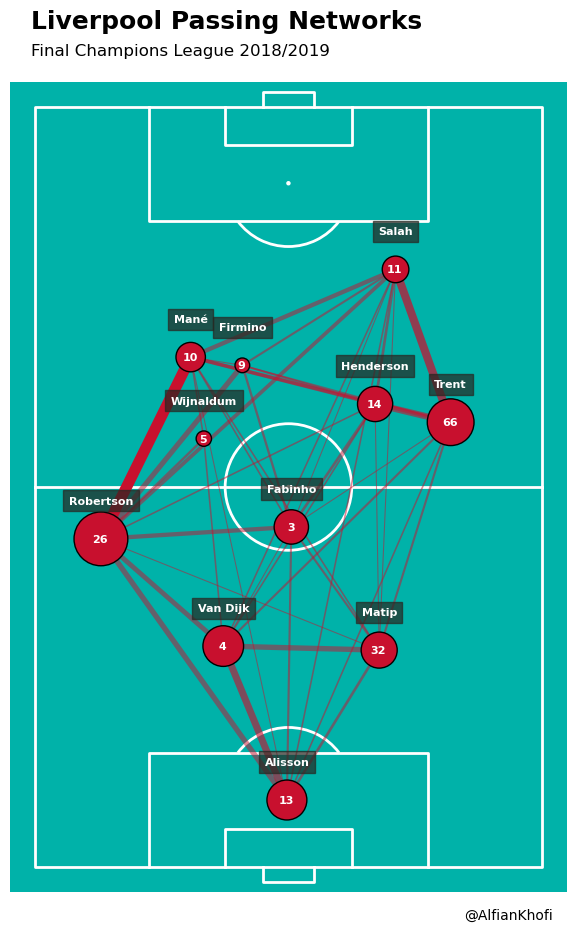

In [145]:
pitch = VerticalPitch(pitch_type='statsbomb',pitch_color='#00B2A9', line_color='white',linewidth=2,goal_type='box')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Plot vertices
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='#C8102E', edgecolors='#000000', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)

#Add Players Name and Jersey Numbers
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x +6, row.y), c='white', va='center',
                   ha='center', size=8, weight = "bold", ax=ax["pitch"], zorder = 4,
                   bbox=dict(facecolor='#272822', alpha=.70, edgecolor='#272822'))
    
for i, row in scatter_df.iterrows():
    pitch.annotate(row.jersey_number, xy=(row.x, row.y-0.1), c='white', va='center',
                   ha='center', size=8, weight = "bold", ax=ax["pitch"], zorder = 4)

#Plot edges
for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 8)
        # adjust the alpha of the lines based on number of passes and set minimum alpha for a fewer pass
        alpha = max(num_passes / lines_df['pass_count'].max(), 0.2)
        alpha = max(alpha, 0.5)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=alpha, lw=line_width, zorder=2, color="#C8102E", ax = ax["pitch"])

fig.text(s="Liverpool Passing Networks", x= 0.06, y= 1, fontsize=18,fontweight="bold")
fig.text(s='Final Champions League 2018/2019', x = 0.06, y=0.97, fontsize=12)
fig.text(s='@AlfianKhofi', x = 0.80, y=0.01, fontsize=10)
plt.savefig('Liverpool_passing_network.png',bbox_inches='tight')
plt.show()

In [146]:
scatter_df1 = pd.DataFrame()
for i, name in enumerate(thfc["player_name"].unique()):
    passx1 = thfc.loc[thfc["player_name"] == name]["x"].to_numpy()
    recx1 = thfc.loc[thfc["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy1 = thfc.loc[thfc["player_name"] == name]["y"].to_numpy()
    recy1 = thfc.loc[thfc["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df1.at[i, "player_name"] = name

    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df1.at[i, "x"] = np.mean(np.concatenate([passx1, recx1]))
    scatter_df1.at[i, "y"] = np.mean(np.concatenate([passy1, recy1]))

    #calculate number of passes
    scatter_df1.at[i, "no"] = thfc.loc[thfc["player_name"] == name].count().iloc[0]
    scatter_df1.at[i, "jersey_number"] = thfc.loc[thfc["player_name"] == name]['jersey_number'].iloc[0]
    scatter_df1['jersey_number'] = scatter_df1['jersey_number'].astype(int)
    
#adjust the size of a circle so that the player who made more passes
scatter_df1['marker_size'] = (scatter_df1['no'] / scatter_df1['no'].max() * 1500)

In [147]:
#Calculate edge width
thfc["pair_key"] = thfc.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df1 = thfc.groupby(["pair_key"]).x.count().reset_index()
lines_df1.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold
lines_df1 = lines_df1[lines_df1['pass_count']>5]

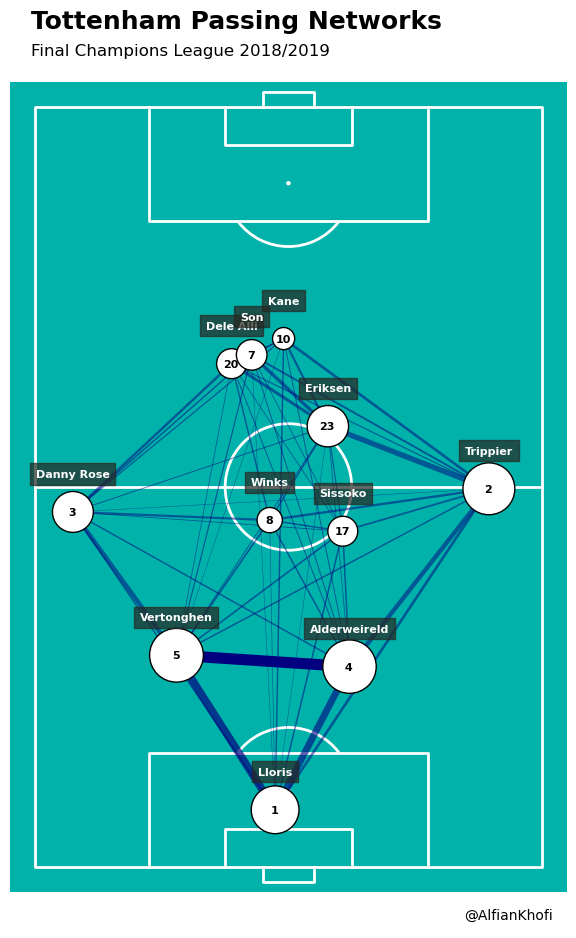

In [149]:
pitch = VerticalPitch(pitch_type='statsbomb',pitch_color='#00B2A9', line_color='white',linewidth=2,goal_type='box')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Plot vertices
pitch.scatter(scatter_df1.x, scatter_df1.y, s=scatter_df1.marker_size, color='white', edgecolors='#000000', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)

#Add Players Name and Jersey Numbers
for i, row in scatter_df1.iterrows():
    pitch.annotate(row.player_name, xy=(row.x +6, row.y), c='white', va='center',
                   ha='center', size=8, weight = "bold", ax=ax["pitch"], zorder = 4,
                   bbox=dict(facecolor='#272822', alpha=.70, edgecolor='#272822'))
    
for i, row in scatter_df1.iterrows():
    pitch.annotate(row.jersey_number, xy=(row.x, row.y-0.1), c='black', va='center',
                   ha='center', size=8, weight = "bold", ax=ax["pitch"], zorder = 4)

#Plot edges
for i, row in lines_df1.iterrows():
        player1a = row["pair_key"].split("_")[0]
        player2a = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x1 = scatter_df1.loc[scatter_df1["player_name"] == player1a]['x'].iloc[0]
        player1_y1 = scatter_df1.loc[scatter_df1["player_name"] == player1a]['y'].iloc[0]
        player2_x1 = scatter_df1.loc[scatter_df1["player_name"] == player2a]['x'].iloc[0]
        player2_y1 = scatter_df1.loc[scatter_df1["player_name"] == player2a]['y'].iloc[0]
        num_passes1 = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width1 = (num_passes1 / lines_df1['pass_count'].max() * 8)
        # adjust the alpha of the lines based on number of passes and set minimum alpha for a fewer pass
        alpha = max(num_passes1 / lines_df1['pass_count'].max(), 0.2)
        alpha = max(alpha, 0.5)
        #plot lines on the pitch
        pitch.lines(player1_x1, player1_y1, player2_x1, player2_y1,
                        alpha=alpha, lw=line_width1, zorder=2, color="navy", ax = ax["pitch"])

fig.text(s="Tottenham Passing Networks", x= 0.06, y= 1, fontsize=18,fontweight="bold")
fig.text(s='Final Champions League 2018/2019', x = 0.06, y=0.97, fontsize=12)
fig.text(s='@AlfianKhofi', x = 0.80, y=0.01, fontsize=10)
plt.savefig('Tottenham_passing_network.png',bbox_inches='tight')
plt.show()